# Reading and Plotting Bottom Data

This script demonstrates how to read .raw and .bot files to plot echograms of the data.

## Initialization
If you do not already have __pyEcholab__ installed using the following pip command in the terminal to install it:
```
pip install git+https://github.com/CI-CMG/pyEcholab.git
```
## Setup

In [1]:
from echolab2.instruments import EK60
from echolab2.plotting.matplotlib import echogram
from echolab2.processing import mask, line
import numpy as np
import pandas as pd
from matplotlib.pyplot import figure, show, subplots_adjust
import os

To access the data we will use the library boto3, which provides an object-oriented interface to Amazon S3 Buckets. We configure the boto3 resource to access the bucket as an anonymous user.

In [2]:
import boto3, botocore
from botocore import UNSIGNED
from botocore.client import Config

s3 = boto3.resource('s3', aws_access_key_id='', aws_secret_access_key='', config=Config(signature_version=UNSIGNED))

BUCKET = 'cires'

## Read S3 Data
Caching files for later use.
Let's start with a .raw file and the corresponding .bot file

In [3]:
rawFiles = ['DY1706_EK60-D20170625-T062521.raw']
bottomFiles = ['DY1706_EK60-D20170625-T062521.bot']
files = rawFiles + bottomFiles

try:
    for file in files:
        if file not in os.listdir('.'): 
            s3.Bucket(BUCKET).download_file('data/raw/EK60/' + file, file)
            print('downloaded:', file)
        else:
            print('already found:', file)
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == "404":
        print("The object does not exist.")
    else:
        raise

already found: DY1706_EK60-D20170625-T062521.raw
already found: DY1706_EK60-D20170625-T062521.bot


# Create an instance of EK60.

In [4]:
ek60 = EK60.EK60()
type(ek60)

echolab2.instruments.EK60.EK60

Read the .raw file

In [5]:
print('reading raw files...')
ek60.read_raw(rawFiles, frequencies=[38000, 120000])

reading raw files...


Read the .bot file

In [6]:
print('reading bot files...')
ek60.read_bot(bottomFiles)

reading bot files...


## Parse the data
Get a reference to the RawData object for specified channels.

In [7]:
raw_data_38 = ek60.get_raw_data(channel_number=1)
raw_data_120 = ek60.get_raw_data(channel_number=2)

Get Sv data

In [8]:
Sv_38_as_depth = raw_data_38.get_Sv(heave_correct=True)
Sv_120_as_depth = raw_data_120.get_Sv(heave_correct=True)

Get the sounder detected bottom data. The astute observer would wonder why we're applying heave correction to the sounder detected bottom since you shouldn't do this (you only correct the underlying sample data which defines the axes). We have chosen to allow the heave_correct keyword in this context to maintain a consistent interface with the get_* methods. When set, no heave correction is applied, but it ensures that get_bottom returns *depth*. You could achieve the same result by setting the return_depth keyword to True.

In [9]:
bottom_38 = raw_data_38.get_bottom(heave_correct=True)
bottom_120 = raw_data_120.get_bottom(heave_correct=True)

## Plotting

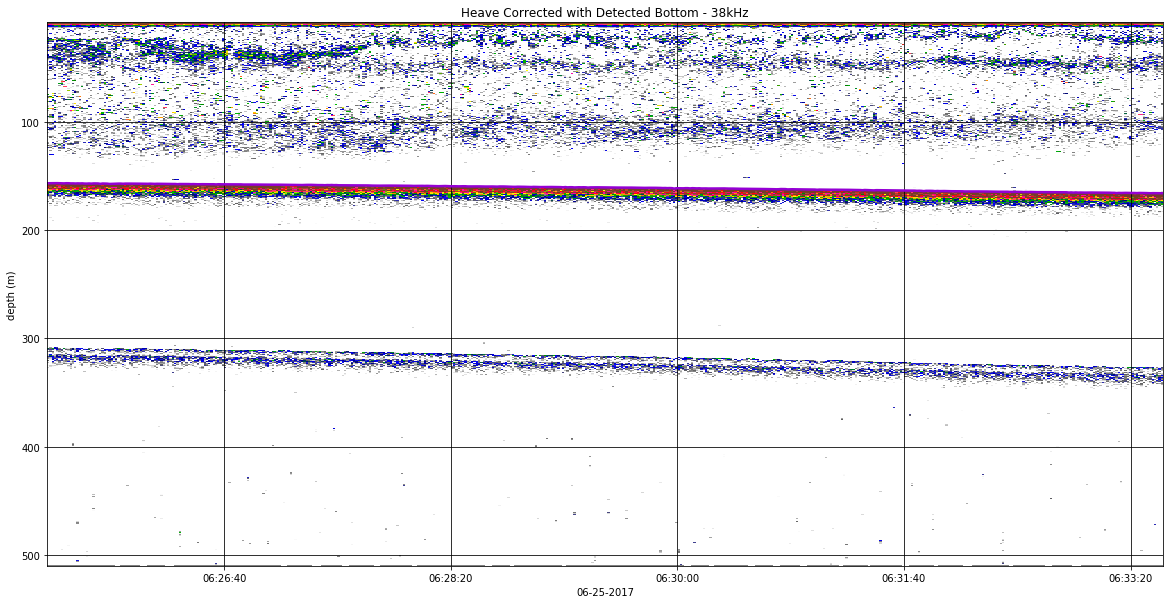

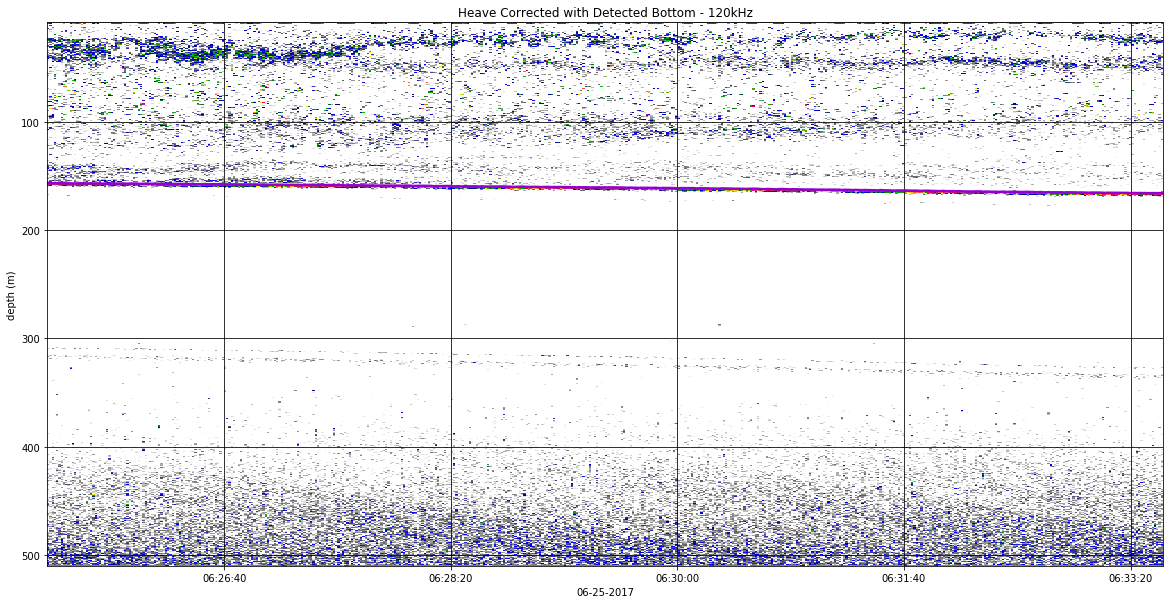

In [10]:
fig_38 = figure(figsize=[20, 10])

eg = echogram.Echogram(fig_38, Sv_38_as_depth, threshold=[-70, -34])
eg.axes.set_title("Heave Corrected with Detected Bottom - 38kHz")
eg.plot_line(bottom_38, linewidth=2.5)

fig_120 = figure(figsize=[20, 10])
eg = echogram.Echogram(fig_120, Sv_120_as_depth, threshold=[-70, -34])
eg.axes.set_title("Heave Corrected with Detected Bottom - 120kHz")
eg.plot_line(bottom_120, linewidth=2.5)

show()